# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [1]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


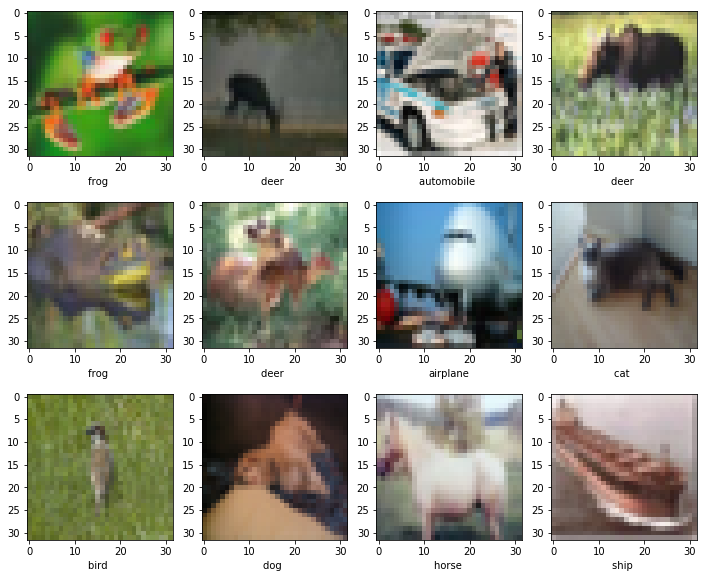

In [2]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [4]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [16]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.FloatTensor(X_batch)
    y_batch = torch.LongTensor(y_batch)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [17]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(1.1884)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [18]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [19]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [10]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.FloatTensor(X_batch))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 1.449s
  training loss (in-iteration): 	2.030924
  validation accuracy: 			34.52 %
Epoch 2 of 100 took 1.879s
  training loss (in-iteration): 	1.854739
  validation accuracy: 			37.02 %
Epoch 3 of 100 took 1.287s
  training loss (in-iteration): 	1.790811
  validation accuracy: 			38.07 %
Epoch 4 of 100 took 1.134s
  training loss (in-iteration): 	1.742963
  validation accuracy: 			39.05 %
Epoch 5 of 100 took 1.048s
  training loss (in-iteration): 	1.704198
  validation accuracy: 			41.27 %
Epoch 6 of 100 took 1.084s
  training loss (in-iteration): 	1.669521
  validation accuracy: 			42.09 %
Epoch 7 of 100 took 1.175s
  training loss (in-iteration): 	1.641256
  validation accuracy: 			43.37 %
Epoch 8 of 100 took 1.022s
  training loss (in-iteration): 	1.614452
  validation accuracy: 			43.52 %
Epoch 9 of 100 took 1.060s
  training loss (in-iteration): 	1.593655
  validation accuracy: 			43.38 %
Epoch 10 of 100 took 1.198s
  training loss (in-iteration): 	1.575226
  v

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [20]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		49.37 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [36]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1))
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(10 * 16 * 16, 100))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('drop1', nn.Dropout(p=0.5))
model.add_module('dense2_logits', nn.Linear(100, 10)) 

In [37]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [38]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.FloatTensor(X_batch))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 8.906s
  training loss (in-iteration): 	2.122379
  validation accuracy: 			33.02 %
Epoch 2 of 100 took 9.720s
  training loss (in-iteration): 	1.916157
  validation accuracy: 			36.91 %
Epoch 3 of 100 took 8.707s
  training loss (in-iteration): 	1.829374
  validation accuracy: 			39.55 %
Epoch 4 of 100 took 8.340s
  training loss (in-iteration): 	1.763100
  validation accuracy: 			41.61 %
Epoch 5 of 100 took 8.554s
  training loss (in-iteration): 	1.713560
  validation accuracy: 			43.72 %
Epoch 6 of 100 took 8.746s
  training loss (in-iteration): 	1.674779
  validation accuracy: 			45.34 %
Epoch 7 of 100 took 9.088s
  training loss (in-iteration): 	1.632643
  validation accuracy: 			46.67 %
Epoch 8 of 100 took 9.226s
  training loss (in-iteration): 	1.599538
  validation accuracy: 			47.71 %
Epoch 9 of 100 took 8.619s
  training loss (in-iteration): 	1.574563
  validation accuracy: 			48.77 %
Epoch 10 of 100 took 8.468s
  training loss (in-iteration): 	1.540300
  v

In [39]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		62.25 %
Achievement unlocked: 70lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [40]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1))
model.add_module('bn1', nn.BatchNorm2d(10))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(10 * 16 * 16, 100))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('drop1', nn.Dropout(p=0.5))
model.add_module('dense2_logits', nn.Linear(100, 10)) 

In [41]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [42]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.FloatTensor(X_batch))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 14.161s
  training loss (in-iteration): 	1.929016
  validation accuracy: 			41.38 %
Epoch 2 of 100 took 13.597s
  training loss (in-iteration): 	1.645133
  validation accuracy: 			48.19 %
Epoch 3 of 100 took 14.104s
  training loss (in-iteration): 	1.506710
  validation accuracy: 			45.09 %
Epoch 4 of 100 took 14.723s
  training loss (in-iteration): 	1.409470
  validation accuracy: 			50.36 %
Epoch 5 of 100 took 13.200s
  training loss (in-iteration): 	1.339440
  validation accuracy: 			56.92 %
Epoch 6 of 100 took 14.062s
  training loss (in-iteration): 	1.290499
  validation accuracy: 			55.42 %
Epoch 7 of 100 took 14.295s
  training loss (in-iteration): 	1.244030
  validation accuracy: 			52.21 %
Epoch 8 of 100 took 14.217s
  training loss (in-iteration): 	1.200666
  validation accuracy: 			58.17 %
Epoch 9 of 100 took 13.375s
  training loss (in-iteration): 	1.166527
  validation accuracy: 			59.89 %
Epoch 10 of 100 took 13.580s
  training loss (in-iteration): 	1.

In [43]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		63.75 %
Achievement unlocked: 70lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [53]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [63]:
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)
valid_loader = CIFAR10("./cifar_data/", train=True, transform=transform_valid)

valid_size = 0.2
num_train = len(train_loader)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=50,
                                              num_workers=1,
                                              sampler=train_sampler)


valid_batch_gen = torch.utils.data.DataLoader(valid_loader,
                                              batch_size=50,
                                              num_workers=1,
                                              sampler=valid_sampler)

In [ ]:

for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        
    
    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [72]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                             batch_size=500,
                                             num_workers=1,
                                             )

In [65]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1))
model.add_module('bn1', nn.BatchNorm2d(10))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(10 * 16 * 16, 100))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('drop1', nn.Dropout(p=0.5))
model.add_module('dense2_logits', nn.Linear(100, 10)) 

In [66]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [70]:
import time
num_epochs = 100 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (x_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(x_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.item())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for (X_batch, y_batch) in valid_batch_gen:
        logits = model(torch.FloatTensor(X_batch))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch.data.numpy() == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 27.954s
  training loss (in-iteration): 	1.850428
  validation accuracy: 			32.06 %
Epoch 2 of 100 took 21.634s
  training loss (in-iteration): 	1.777216
  validation accuracy: 			35.98 %
Epoch 3 of 100 took 21.438s
  training loss (in-iteration): 	1.733555
  validation accuracy: 			38.40 %
Epoch 4 of 100 took 23.848s
  training loss (in-iteration): 	1.696189
  validation accuracy: 			39.76 %
Epoch 5 of 100 took 23.120s
  training loss (in-iteration): 	1.668765
  validation accuracy: 			41.68 %
Epoch 6 of 100 took 21.231s
  training loss (in-iteration): 	1.645363
  validation accuracy: 			44.26 %
Epoch 7 of 100 took 20.867s
  training loss (in-iteration): 	1.628657
  validation accuracy: 			46.01 %
Epoch 8 of 100 took 21.309s
  training loss (in-iteration): 	1.613786
  validation accuracy: 			46.69 %
Epoch 9 of 100 took 20.290s
  training loss (in-iteration): 	1.593594
  validation accuracy: 			47.22 %
Epoch 10 of 100 took 20.734s
  training loss (in-iteration): 	1.

Process Process-151:
Traceback (most recent call last):
  File "/home/apodolskiy/anaconda3/envs/torchEnv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/apodolskiy/anaconda3/envs/torchEnv/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/apodolskiy/anaconda3/envs/torchEnv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/apodolskiy/anaconda3/envs/torchEnv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/apodolskiy/anaconda3/envs/torchEnv/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/cifar.py", line 121, in __getitem__
    img = self.transform(img)
  File "/home/apodolskiy/anaconda3/envs/torchEnv/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/home/apodolskiy/anaconda3/envs/torchEnv/lib/python3.6/site-packages/tor

In [73]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for (X_batch, y_batch) in test_batch_gen:
    logits = model(torch.FloatTensor(X_batch))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch.data.numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		56.96 %
Achievement unlocked: 60lvl Warlock!


Network needs much more time and deeper architecture to learn well on data augmented dataset.

## The Quest For A Better Network

See `practical_dl/homework02` for a full-scale assignment.